 http://www.snap-tck.com/room04/c01/stat/stat01/stat0106.html#note03

In [1]:
using Logging
disable_logging(Logging.Warn)

using Distributions
using Roots
using Memoization
using Plots
using RCall
@rlibrary stats

x ⪅ y = x < y || x ≈ y

function pvalue(d, k, ::Val{:ts}) # :ts stands for "two-sided"
    sum(pdf(d, j) for j in support(d) if pdf(d, j) ⪅ pdf(d, k); init = 0.0)
end

function pvalue(d, k, ::Val{:dos}) # :dos stands for "doubled one-sided"
    min(1, 2cdf(d, k), 2ccdf(d, k-1))
end

@memoize function pvalue(a, b, c, d, ::Val{:fisher}; ω = 1.0)
    iszero(a+c) || iszero(b+d) && return 1.0
    pvalue(FisherNoncentralHypergeometric(a+b, c+d, a+c, ω), a, Val(:ts))
end

@memoize function pvalue(a, b, c, d, ::Val{:fisher_dos}; ω = 1.0)
    iszero(a+c) || iszero(b+d) && return 1.0
    pvalue(FisherNoncentralHypergeometric(a+b, c+d, a+c, ω), a, Val(:dos))
end

@memoize function confidence_interval(a, b, c, d, alg; α = 0.05)
    CI = exp.(find_zeros(t -> pvalue(a, b, c, d, alg; ω = exp(t)) - α, -20, 20))
    isone(length(CI)) ? CI[1] < 1 ? (0.0, CI[1]) : (CI[1], Inf) : (CI[1], CI[end])
end

function delta(a, b, c, d, ω=1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    2*C/(-B - √(B^2 - 4*A*C))
end

_odds_ratio(a, b, c, d) = (ad = a*d; iszero(ad) ? ad : ad/(b*c))
function odds_ratio(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    _odds_ratio(a + δ, b - δ, c - δ, d + δ)
end

_chisq(a, b, c, d) = (a+b+c+d)*(a*d - b*c)^2/((a+b)*(c+d)*(a+c)*(b+d))
function chisq(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    iszero(δ) ? δ : δ^2 * (1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

function chisq_yates(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    m = max(0, abs(δ)-1/2)^2
    iszero(m) ? m : m * (1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

@memoize function pvalue(a, b, c, d, ::Val{:chisq}; ω = 1.0)
    ccdf(Chisq(1), chisq(a, b, c, d, ω))
end

@memoize function pvalue(a, b, c, d, ::Val{:chisq_yates}; ω = 1.0)
    ccdf(Chisq(1), chisq_yates(a, b, c, d, ω))
end

pvalue (generic function with 6 methods)

In [2]:
println("="^30 * " Test data:\n")

A = [16 4; 4 6]
@show A
println()

println("="^30 * " Calculated by R:\n")
@show rcopy(fisher_test(A))[:p_value]
@show rcopy(fisher_test(A))[:conf_int]
println()
@show rcopy(chisq_test(A, correct=false))[:p_value]
@show rcopy(chisq_test(A))[:p_value]

sleep(0.1)
println()

println("="^30 * " Calculated by Julia:\n")
@show pvalue(A..., Val(:fisher))
@show confidence_interval(A..., Val(:fisher))
@show pvalue(A..., Val(:fisher_dos))
@show confidence_interval(A..., Val(:fisher_dos))
println()
@show pvalue(A..., Val(:chisq))
@show confidence_interval(A..., Val(:chisq))
@show pvalue(A..., Val(:chisq_yates))
@show confidence_interval(A..., Val(:chisq_yates))
;

============================== Test data:

A = [16 4; 4 6]

============================== Calculated by R:

(rcopy(fisher_test(A)))[:p_value] = 0.04485792401834373
(rcopy(fisher_test(A)))[:conf_int] = [0.8602909481155422, 44.00171912708482]

(rcopy(chisq_test(A, correct = false)))[:p_value] = 0.028459736916310548
(rcopy(chisq_test(A)))[:p_value] = 0.07505987281783368

============================== Calculated by Julia:

pvalue(A..., Val(:fisher)) = 0.04485792401834382
confidence_interval(A..., Val(:fisher)) = (1.0548936562756734, 32.69944128327747)
pvalue(A..., Val(:fisher_dos)) = 0.07741723543822498
confidence_interval(A..., Val(:fisher_dos)) = (0.8602702455780803, 43.98182262822144)

pvalue(A..., Val(:chisq)) = 0.028459736916310548
confidence_interval(A..., Val(:chisq)) = (1.1911176901272547, 30.49633585876286)
pvalue(A..., Val(:chisq_yates)) = 0.07505987281783368
confidence_interval(A..., Val(:chisq_yates)) = (0.8734133287988821, 47.22191280527806)


In [3]:
fisher_test(A)

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [4]:
chisq_test(A, correct = false)

RObject{VecSxp}

	Pearson's Chi-squared test

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
X-squared = 4.8, df = 1, p-value = 0.02846



In [5]:
chisq_test(A)

RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
X-squared = 3.1687, df = 1, p-value = 0.07506



In [6]:
ecdf(A, x) = count(≤(x), A)/length(A)

function multinomial_null(a, b, c, d)
    n = a + b + c + d
    pa = (a+b)*(a+c)/n^2
    pb = (a+b)*(b+d)/n^2
    pc = (c+d)*(a+c)/n^2
    pd = (c+d)*(b+d)/n^2
    Multinomial(n, [pa, pb, pc, pd])
end

null = multinomial_null(A...)
L = 10^5
X = rand(null, L)
@time pvalue_fisher = vec(mapslices(A -> pvalue(A..., Val(:fisher)), X; dims=1))
@time pvalue_fisher_dos = vec(mapslices(A -> pvalue(A..., Val(:fisher_dos)), X; dims=1))
@time pvalue_chisq = vec(mapslices(A -> pvalue(A..., Val(:chisq)), X; dims=1))
@time pvalue_chisq_yates = vec(mapslices(A -> pvalue(A..., Val(:chisq_yates)), X; dims=1));

  0.778656 seconds (3.90 M allocations: 193.765 MiB, 5.29% gc time, 91.73% compilation time)
  0.178346 seconds (1.61 M allocations: 50.607 MiB, 7.75% gc time, 64.11% compilation time)
  0.177429 seconds (1.56 M allocations: 47.915 MiB, 7.02% gc time, 64.27% compilation time)
  0.146506 seconds (1.49 M allocations: 42.956 MiB, 63.82% compilation time)


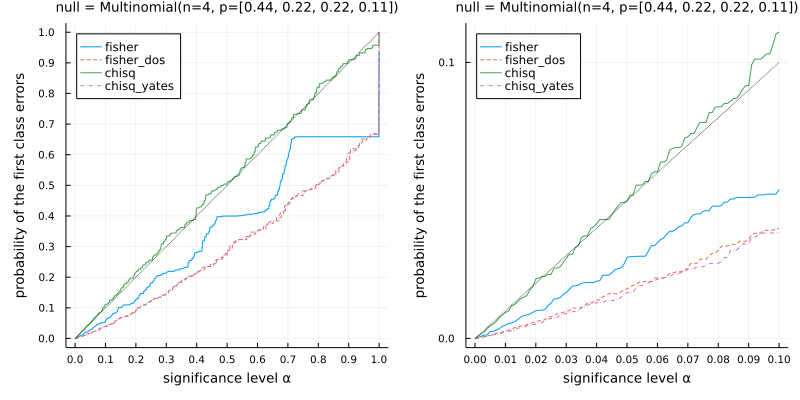

In [7]:
p = range(0, 1; length=1001)
P = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=0:0.1:1, ytick=0:0.1:1, tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ncategories(null)), p=$(round.(probs(null); digits=2)))", titlefontsize=9)

p = range(0, 0.1; length=101)
Q = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=0:0.01:0.1, ytick=0:0.1:1, tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ncategories(null)), p=$(round.(probs(null); digits=2)))", titlefontsize=9)

plot(P, Q; size=(800, 400), left_margin=5Plots.mm, bottom_margin=5Plots.mm)